# Modelo Regresión Logística: Encuesta Reddit Chile

## Conexión a fuente de datos

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

In [4]:
df.head()

,edad,religion,sexo_Hombre,sexo_Mujer,orientacion_Bisexual,orientacion_Heterosexual,orientacion_Homosexual,ocupacion_Estudio,ocupacion_Ninguna,ocupacion_Trabajo,...,deporte_4horas,perro_agua,perro_atom_humber,perro_bus,perro_chilaquil,perro_ladron,perro_lipigas,perro_matapacos,perro_washington,perro_waton
0,27,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,30,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,26,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,18,1,1,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,19,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Selección de variables predictoras y de respuesta.

In [5]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [7]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train==1]
y_train_NQ = y_train[y_train==0]
y_train_Q = y_train_Q.sample(len(y_train_NQ), replace=True, random_state= 42)
y_train = pd.concat([y_train_Q,y_train_NQ],axis=0)
y_train.value_counts()
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

# Cross-Validation y Grid-Search

## solo Cross-Validation:

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# modelo logístico base
logit_cv = LogisticRegression(max_iter = 10000, random_state = 42)
logit_cv = logit_cv.fit(X, y)
# Validación cruzada
cv = cross_validate(logit_cv,
                    X,
                    y,
                    cv = 3,
                    n_jobs = 2,
                    return_train_score = True)
cv

{'fit_time': array([0.07479978, 0.07878852, 0.06234026]),
 'score_time': array([0.00299191, 0.00299287, 0.00199437]),
 'test_score': array([0.65128205, 0.60512821, 0.59487179]),
 'train_score': array([0.68333333, 0.66666667, 0.67307692])}

## Grid-Search con Cross-Validation

In [18]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV

grilla = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'penalty': ['l2', 'l1', 'none']}
reglog = LogisticRegression(max_iter = 10000, 
                            random_state = 42, 
                            n_jobs = 2,
                            solver = 'saga')
reglog_cv = GridSearchCV(reglog, grilla, cv= 3, n_jobs = 2, 
                         scoring = 'accuracy')
reglog_cv.fit(X_train, y_train)

print('Mejores hiperparámetros:',reglog_cv.best_params_)
print('Accuracy:', reglog_cv.best_score_)

# https://www.kaggle.com/code/enespolat/grid-search-with-logistic-regression/notebook

Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.6456178528759174


# Ajuste modelo

In [19]:
modelo = reglog_cv.best_estimator_

In [20]:
modelo.fit(X_train,y_train)

LogisticRegression(C=0.1, max_iter=10000, n_jobs=2, random_state=42,
                   solver='saga')

# Resultados modelo

## Métricas

In [21]:
y_pred_train = modelo.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=["Y_predicha"], 
                            index = y_train.index)

from sklearn.metrics import classification_report
print("Resultado en data de entrenamiento:")

print(classification_report(y_train, y_pred_train))

Resultado en data de entrenamiento:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       419
           1       0.71      0.65      0.67       419

    accuracy                           0.69       838
   macro avg       0.69      0.69      0.69       838
weighted avg       0.69      0.69      0.69       838



In [22]:
y_pred_test = modelo.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=["Y_predicha"], 
                           index = y_test.index)

print("Resultado en data de prueba:")

print(classification_report(y_test, y_pred_test))

Resultado en data de prueba:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       117
           1       0.66      0.60      0.63       117

    accuracy                           0.65       234
   macro avg       0.65      0.65      0.64       234
weighted avg       0.65      0.65      0.64       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 66% de las veces.  
**Recall**: El modelo es capaz de identificar el 60% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 65% de las veces.

## Curva ROC & AUC

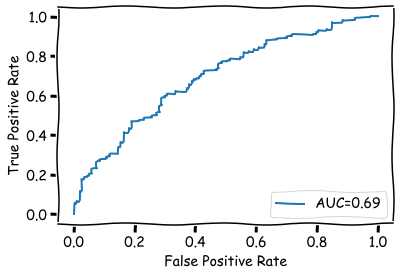

In [30]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## PR

In [31]:
pr = metrics.precision_recall_curve(y_test, y_prob_test)

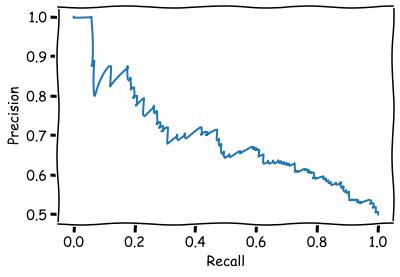

In [32]:
with plt.xkcd():
    plt.plot(pr[1], pr[0])
    plt.xlabel("Recall")
    plt.ylabel("Precision")

## Betas y odds-ratio

In [33]:
betas = pd.DataFrame(modelo.coef_, columns=X.columns)
betas = betas.T
betas['abs'] = abs(betas[0])
betas.drop(['abs'], axis=1, inplace = True)
betas.columns = ['betas']
betas['odds_ratio'] = np.exp(betas['betas'])
betas.sort_values(by=['odds_ratio'], ascending = False, inplace = True)
betas = betas[['odds_ratio', 'betas']]
print(betas)

                           odds_ratio     betas
perro_matapacos              2.535754  0.930491
orientacion_Homosexual       1.386700  0.326927
orientacion_Bisexual         1.330893  0.285850
educacion_posgrado           1.273218  0.241547
ocupacion_Ninguna            1.268474  0.237814
region_IV                    1.235880  0.211783
region_XVI                   1.208684  0.189532
ocupacion_Trabajo;Estudio    1.206995  0.188134
sexo_Mujer                   1.132670  0.124578
deporte_2horas               1.129391  0.121678
region_V                     1.104205  0.099126
region_X                     1.097133  0.092700
region_RM                    1.086068  0.082563
region_I                     1.059200  0.057514
musica_Rap                   1.056536  0.054995
musica_Rock                  1.051039  0.049779
region_XII                   1.047164  0.046085
sexo_Hombre                  1.037005  0.036337
perro_chilaquil              1.036864  0.036201
region_VIII                  1.028439  0

Por ejemplo, las chances de que una persona sea de tendencia política de izquierda, teniendo como perro favorito al Perro Matapacos es son 2.53 veces más las chances de una persona que sea de tendencia de izquierda que no tenga elección de perro favorito, considerando las variables restantes tomen valores iguales.